In [1]:
import tensorflow as tf
from tensorflow.python.keras.backend import set_session
import os
import random
import numpy as np


from tqdm import tqdm 

from PIL import Image
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold

2025-03-28 14:36:40.342279: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-28 14:36:40.342324: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-28 14:36:40.342968: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-28 14:36:40.346898: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-28 14:36:40.836095: W tensorflow/compiler/tf2

In [2]:
num_classes = 1
k = 5


IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1

DATA_PATH = 'data2/'

data_ids = next(os.walk(DATA_PATH+'/image'))[2]
data_ids = sorted(data_ids,  key=lambda x: int(x.split('.')[0]))
X = np.zeros((len(data_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y = np.zeros((len(data_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_ALLOCATOR']= 'cuda_malloc_async'


In [3]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(data_ids), total=len(data_ids)):   
    path = DATA_PATH
    img = imread(path + '/image/' + id_, as_gray=True)[:,:]
    img = img.reshape(img.shape[0], img.shape[1], IMG_CHANNELS)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img  #Fill empty X_train with values from img
    
    mask = imread(path + 'label/' + id_, as_gray=True)
    mask = (mask >= 1)
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
    y[n] = mask
    #plt.axis("off")
    #imshow(y[n])
    #plt.show()

Resizing training images and masks


100%|█████████████████████████████████████████████████████████████████████████████████| 490/490 [00:12<00:00, 38.36it/s]


In [4]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input image', 'True mask', 'UNet', 'UNet++', 'UNet3Plus', 'TransUNet']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap='gray')
    plt.axis('off')
  plt.show()

In [5]:
@tf.keras.utils.register_keras_serializable()
def f1_score(y_true, y_pred):
    """Calcula o F1-Score para segmentação binária"""
    y_pred = K.round(y_pred)  # Arredondar para 0 ou 1
    tp = K.sum(K.cast(y_true * y_pred, 'float32'))  # Verdadeiros Positivos
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float32'))  # Falsos Positivos
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float32'))  # Falsos Negativos
    
    precision = tp / (tp + fp + K.epsilon())  # Precision
    recall = tp / (tp + fn + K.epsilon())  # Recall
    
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())  # F1-Score
    return f1

In [6]:
@tf.keras.utils.register_keras_serializable()
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

In [7]:
from tensorflow.keras.layers import (
    Conv2D, Dropout, BatchNormalization, ReLU, MaxPooling2D,
    Conv2DTranspose, Concatenate, Reshape, Dense, LayerNormalization,
    MultiHeadAttention, Input
)
from tensorflow.keras.models import Model

@tf.keras.utils.register_keras_serializable()
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, num_patches, d_model):
        super(PositionalEmbedding, self).__init__()
        self.pos_emb = self.add_weight(
            shape=(1, num_patches, d_model),
            initializer='zeros',
            trainable=True,
            name='positional_embedding'
        )

    def call(self, inputs):
        return inputs + self.pos_emb

def trans_unet():
    input_shape =  (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    inputs = Input(input_shape)
    
    def conv_block(x, filters, dropout=0.1):
        x = Conv2D(filters, (3, 3), activation='relu', 
                 kernel_initializer='he_normal', padding='same')(x)
        x = Dropout(dropout)(x)
        x = Conv2D(filters, (3, 3), activation='relu', 
                 kernel_initializer='he_normal', padding='same')(x)
        x = BatchNormalization()(x)
        return ReLU()(x)
    
    # Encoder (CNN)
    c1 = conv_block(inputs, 16)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = conv_block(p1, 32)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = conv_block(p2, 64, dropout=0.2)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = conv_block(p3, 128, dropout=0.2)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Transformer Bottleneck
    h = input_shape[0] // 16
    w = input_shape[1] // 16
    num_patches = h * w
    d_model = 256
    
    x = Reshape((num_patches, 128))(p4)
    x = Dense(d_model)(x)
    x = PositionalEmbedding(num_patches, d_model)(x)
    
    # Transformer Encoder
    num_heads = 8
    for _ in range(4):
        x1 = LayerNormalization()(x)
        attn = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(x1, x1)
        x = attn + x
        x2 = LayerNormalization()(x)
        mlp = Dense(d_model * 4, activation='gelu')(x2)
        mlp = Dense(d_model)(mlp)
        x = mlp + x
    
    x = Reshape((h, w, d_model))(x)
    
    # Decoder (UNet++ style)
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    u6 = Concatenate()([u6, c4])
    c6 = conv_block(u6, 128)
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = Concatenate()([u7, c3])
    c7 = conv_block(u7, 64)
    
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = Concatenate()([u8, c2])
    c8 = conv_block(u8, 32)
    
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = Concatenate()([u9, c1])
    c9 = conv_block(u9, 16)
    
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss=dice_loss, metrics=[
        'accuracy', 
        tf.keras.metrics.Recall(name='recall'), 
        tf.keras.metrics.Precision(name='precision'),
        f1_score,
        tf.keras.metrics.IoU(num_classes=2, target_class_ids={0,1}, name='IoU')
    ])
    
    return model


In [20]:
modelU = tf.keras.models.load_model('Best Models/UNet.keras')
modelUP = tf.keras.models.load_model('Best Models/UNetPlus.keras')
modelU3 = tf.keras.models.load_model('Best Models/UNet3Plus.keras')
modelTU = tf.keras.models.load_model('Best Models/TransUNet.keras')

2025-03-26 16:04:25.508561: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


1/1 [==============================] - 1s 546ms/step


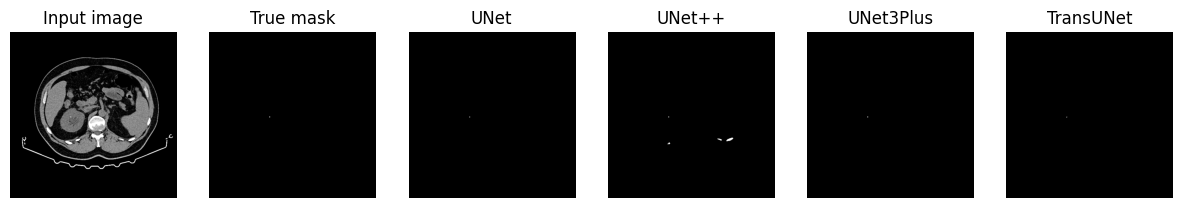

Dice U-Net: 0.923076923076923
Dice U-Net++: 0.0660377358490566
Dice U-Net3+: 1.0
Dice TansUNet: 0.8333333333333333


In [9]:
#i = random.randint(0, len(X))
i = 144
sample_image = X[i]
sample_mask = y[i]

predictionU = modelU.predict(sample_image[tf.newaxis, ...])[0]
predicted_maskU = (predictionU > 0.5).astype(np.uint8)
predictionUP = modelUP.predict(sample_image[tf.newaxis, ...])[0]
predicted_maskUP = (predictionUP > 0.5).astype(np.uint8)
predictionU3 = modelU3.predict(sample_image[tf.newaxis, ...])[0]
predicted_maskU3 = (predictionU3 > 0.5).astype(np.uint8)
predictionTU = modelTU.predict(sample_image[tf.newaxis, ...])[0]
predicted_maskTU = (predictionTU > 0.5).astype(np.uint8)
display([sample_image, sample_mask, predicted_maskU, predicted_maskUP, predicted_maskU3, predicted_maskTU])


#cv2.imwrite("Result Images/original"+str(i)+".png", sample_image)
#cv2.imwrite("Result Images/groundtruth"+str(i)+".png", (sample_mask > 0.5).astype(np.uint8)*255)
cv2.imwrite("Results_new/UNet/"+str(i)+"_UNet.png", predicted_maskU*255)
cv2.imwrite("Results_new/UNet++/"+str(i)+"_UNet++.png", predicted_maskU*255)
cv2.imwrite("Results_new/UNet3+/"+str(i)+"_UNet3+.png", predicted_maskU3*255)
cv2.imwrite("Results_new/TransUNet/"+str(i)+"_TransUNet.png", predicted_maskTU*255)

sample_mask = y[i].astype(np.uint8).flatten()
predicted_maskU = predicted_maskU.flatten()
predicted_maskUP = predicted_maskUP.flatten()
predicted_maskU3 = predicted_maskU3.flatten()
predicted_maskTU = predicted_maskTU.flatten()


print("Dice U-Net: "+ str((2*jaccard_score(sample_mask, predicted_maskU))/(1+jaccard_score(sample_mask, predicted_maskU))))
print("Dice U-Net++: "+ str((2*jaccard_score(sample_mask, predicted_maskUP))/(1+jaccard_score(sample_mask, predicted_maskUP))))
print("Dice U-Net3+: "+ str((2*jaccard_score(sample_mask, predicted_maskU3))/(1+jaccard_score(sample_mask, predicted_maskU3))))
print("Dice TansUNet: "+ str((2*jaccard_score(sample_mask, predicted_maskTU))/(1+jaccard_score(sample_mask, predicted_maskTU))))

In [21]:
totalDiceU = []
totalDiceUP = []
totalDiceU3 = []
totalDiceTU = []

right_kidney_stone = range(140, 145)
left_kidney_stone = range(195, 198)
ureter_stone = range(211, 220)
bladder_stone = range(424, 433)

stones_location = [right_kidney_stone, left_kidney_stone, ureter_stone]
location_names = ["Right Kidney Stone", "Left Kidney Stone", "Ureter Stone", "Bladder Stone"]

name = 0
for location_range in stones_location:
    locationDiceU = []
    locationDiceUP = []
    locationDiceU3 = []
    locationDiceTU = []
    print(location_names[name])
    for i in location_range: 
        sample_image = X[i]
        sample_mask = y[i]
        
        predictionU = modelU.predict(sample_image[tf.newaxis, ...])[0]
        predicted_maskU = (predictionU > 0.5).astype(np.uint8)
        predictionUP = modelUP.predict(sample_image[tf.newaxis, ...])[0]
        predicted_maskUP = (predictionUP > 0.5).astype(np.uint8)
        predictionU3 = modelU3.predict(sample_image[tf.newaxis, ...])[0]
        predicted_maskU3 = (predictionU3 > 0.5).astype(np.uint8)
        predictionTU = modelTU.predict(sample_image[tf.newaxis, ...])[0]
        predicted_maskTU = (predictionTU > 0.5).astype(np.uint8)
        #display([sample_image, sample_mask, predicted_maskU, predicted_maskUP, predicted_maskU3])
        
        output_dirU = "Results_new/"+location_names[name]+"/UNet/"
        os.makedirs(output_dirU, exist_ok=True)  # Garante que a pasta existe
        cv2.imwrite(output_dirU+str(i)+".png", predicted_maskU*255)

        output_dirUP = "Results_new/"+location_names[name]+"/UNet++/"
        os.makedirs(output_dirUP, exist_ok=True)  # Garante que a pasta existe
        cv2.imwrite(output_dirUP+str(i)+".png", predicted_maskUP*255)

        output_dirU3 = "Results_new/"+location_names[name]+"/UNet3+/"
        os.makedirs(output_dirU3, exist_ok=True)  # Garante que a pasta existe
        cv2.imwrite(output_dirU3+str(i)+".png", predicted_maskU3*255)

        output_dirTU = "Results_new/"+location_names[name]+"/TransUNet/"
        os.makedirs(output_dirTU, exist_ok=True)  # Garante que a pasta existe
        cv2.imwrite(output_dirTU+str(i)+".png", predicted_maskTU*255)
        
        sample_mask = y[i].astype(np.uint8).flatten()
        predicted_maskU = predicted_maskU.flatten()
        predicted_maskUP = predicted_maskUP.flatten()
        predicted_maskU3 = predicted_maskU3.flatten()
        predicted_maskTU = predicted_maskTU.flatten()
        
        DiceU = (2*jaccard_score(sample_mask, predicted_maskU))/(1+jaccard_score(sample_mask, predicted_maskU))
        DiceUP = (2*jaccard_score(sample_mask, predicted_maskUP))/(1+jaccard_score(sample_mask, predicted_maskUP))
        DiceU3 = (2*jaccard_score(sample_mask, predicted_maskU3))/(1+jaccard_score(sample_mask, predicted_maskU3))
        DiceTU = (2*jaccard_score(sample_mask, predicted_maskTU))/(1+jaccard_score(sample_mask, predicted_maskTU))
    
        
        locationDiceU.append(DiceU)
        locationDiceUP.append(DiceUP)
        locationDiceU3.append(DiceU3)
        locationDiceTU.append(DiceTU)

        
    print("Dice U-Net: "+ str(np.mean(locationDiceU)))
    print("Dice U-Net++: "+ str(np.mean(locationDiceUP)))
    print("Dice U-Net3+: "+ str(np.mean(locationDiceU3)))
    print("Dice TransU-Net: "+ str(np.mean(locationDiceTU)))

    totalDiceU.append(np.mean(locationDiceU))
    totalDiceUP.append(np.mean(locationDiceUP))
    totalDiceU3.append(np.mean(locationDiceU3))
    totalDiceTU.append(np.mean(locationDiceTU))

    name += 1
    
print("Dice U-Net: "+ str(np.mean(totalDiceU)))
print("Dice U-Net++: "+ str(np.mean(totalDiceUP)))
print("Dice U-Net3+: "+ str(np.mean(totalDiceU3)))
print("Dice TransU-Net: "+ str(np.mean(totalDiceTU)))

Right Kidney Stone
1/1 [==============================] - 0s 54ms/step
Dice U-Net: 0.825205446727186
Dice U-Net++: 0.05304765811189251
Dice U-Net3+: 0.8192857142857143
Dice TransU-Net: 0.845
Left Kidney Stone
1/1 [==============================] - 0s 55ms/step
Dice U-Net: 0.8755354449472096
Dice U-Net++: 0.8025925925925925
Dice U-Net3+: 0.7672189733593241
Dice TransU-Net: 0.567843137254902
Ureter Stone
1/1 [==============================] - 0s 55ms/step
Dice U-Net: 0.663085225909651
Dice U-Net++: 0.924126407421476
Dice U-Net3+: 0.9353741405965468
Dice TransU-Net: 0.9249753142896684
Dice U-Net: 0.7879420391946822
Dice U-Net++: 0.5932555527086537
Dice U-Net3+: 0.8406262760805284
Dice TransU-Net: 0.7792728171815234


In [16]:
#Data Augmentation Models

modelU = tf.keras.models.load_model('Best Models/UNet_DA.keras')
modelUP = tf.keras.models.load_model('Best Models/UNetPlus_DA.keras')
modelU3 = tf.keras.models.load_model('Best Models/UNet3Plus_DA.keras')
modelTU = tf.keras.models.load_model('Best Models/TransUNet_DA.keras')

In [18]:
totalDiceU = []
totalDiceUP = []
totalDiceU3 = []
totalDiceTU = []

right_kidney_stone = range(140, 145)
left_kidney_stone = range(195, 198)
ureter_stone = range(211, 220)
bladder_stone = range(424, 433)

stones_location = [right_kidney_stone, left_kidney_stone, ureter_stone]
location_names = ["Right Kidney Stone", "Left Kidney Stone", "Ureter Stone", "Bladder Stone"]

name = 0
for location_range in stones_location:
    locationDiceU = []
    locationDiceUP = []
    locationDiceU3 = []
    locationDiceTU = []
    print(location_names[name])
    for i in location_range: 
        sample_image = X[i]
        sample_mask = y[i]
        
        predictionU = modelU.predict(sample_image[tf.newaxis, ...])[0]
        predicted_maskU = (predictionU > 0.5).astype(np.uint8)
        predictionUP = modelUP.predict(sample_image[tf.newaxis, ...])[0]
        predicted_maskUP = (predictionUP > 0.5).astype(np.uint8)
        predictionU3 = modelU3.predict(sample_image[tf.newaxis, ...])[0]
        predicted_maskU3 = (predictionU3 > 0.5).astype(np.uint8)
        predictionTU = modelTU.predict(sample_image[tf.newaxis, ...])[0]
        predicted_maskTU = (predictionTU > 0.5).astype(np.uint8)
        #display([sample_image, sample_mask, predicted_maskU, predicted_maskUP, predicted_maskU3])
        
        output_dirU = "Results_new_DA/"+location_names[name]+"/UNet/"
        os.makedirs(output_dirU, exist_ok=True)  # Garante que a pasta existe
        cv2.imwrite(output_dirU+str(i)+".png", predicted_maskU*255)

        output_dirUP = "Results_new_DA/"+location_names[name]+"/UNet++/"
        os.makedirs(output_dirUP, exist_ok=True)  # Garante que a pasta existe
        cv2.imwrite(output_dirUP+str(i)+".png", predicted_maskUP*255)

        output_dirU3 = "Results_new_DA/"+location_names[name]+"/UNet3+/"
        os.makedirs(output_dirU3, exist_ok=True)  # Garante que a pasta existe
        cv2.imwrite(output_dirU3+str(i)+".png", predicted_maskU3*255)

        output_dirTU = "Results_new_DA/"+location_names[name]+"/TransUNet/"
        os.makedirs(output_dirTU, exist_ok=True)  # Garante que a pasta existe
        cv2.imwrite(output_dirTU+str(i)+".png", predicted_maskTU*255)
        
        sample_mask = y[i].astype(np.uint8).flatten()
        predicted_maskU = predicted_maskU.flatten()
        predicted_maskUP = predicted_maskUP.flatten()
        predicted_maskU3 = predicted_maskU3.flatten()
        predicted_maskTU = predicted_maskTU.flatten()
        
        DiceU = (2*jaccard_score(sample_mask, predicted_maskU))/(1+jaccard_score(sample_mask, predicted_maskU))
        DiceUP = (2*jaccard_score(sample_mask, predicted_maskUP))/(1+jaccard_score(sample_mask, predicted_maskUP))
        DiceU3 = (2*jaccard_score(sample_mask, predicted_maskU3))/(1+jaccard_score(sample_mask, predicted_maskU3))
        DiceTU = (2*jaccard_score(sample_mask, predicted_maskTU))/(1+jaccard_score(sample_mask, predicted_maskTU))
    
        
        locationDiceU.append(DiceU)
        locationDiceUP.append(DiceUP)
        locationDiceU3.append(DiceU3)
        locationDiceTU.append(DiceTU)

        
    print("Dice U-Net: "+ str(np.mean(locationDiceU)))
    print("Dice U-Net++: "+ str(np.mean(locationDiceUP)))
    print("Dice U-Net3+: "+ str(np.mean(locationDiceU3)))
    print("Dice TransU-Net: "+ str(np.mean(locationDiceTU)))

    totalDiceU.append(np.mean(locationDiceU))
    totalDiceUP.append(np.mean(locationDiceUP))
    totalDiceU3.append(np.mean(locationDiceU3))
    totalDiceTU.append(np.mean(locationDiceTU))

    name += 1
    
print("Dice U-Net: "+ str(np.mean(totalDiceU)))
print("Dice U-Net++: "+ str(np.mean(totalDiceUP)))
print("Dice U-Net3+: "+ str(np.mean(totalDiceU3)))
print("Dice TransU-Net: "+ str(np.mean(totalDiceTU)))

Right Kidney Stone
1/1 [==============================] - 0s 28ms/step
Dice U-Net: 0.8405900621118013
Dice U-Net++: 0.8405900621118013
Dice U-Net3+: 0.8490111147433803
Dice TransU-Net: 0.8405900621118013
Left Kidney Stone
1/1 [==============================] - 0s 32ms/step
Dice U-Net: 0.8178431372549019
Dice U-Net++: 0.8345098039215687
Dice U-Net3+: 0.8345098039215687
Dice TransU-Net: 0.8467320261437908
Ureter Stone
1/1 [==============================] - 0s 41ms/step
Dice U-Net: 0.6049979217337268
Dice U-Net++: 0.7394225627108105
Dice U-Net3+: 0.9199975686144563
Dice TransU-Net: 0.7257258328985929
Dice U-Net: 0.75447704036681
Dice U-Net++: 0.8048408095813935
Dice U-Net3+: 0.8678394957598018
Dice TransU-Net: 0.8043493070513951
